# データの学習

Pytorch で深層学習モデルを構築し、データを学習・評価する．

In [1]:
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
INPUT_DIM = 5
OUTPUT_DIM = 2
HIDDEN_DIM = 10

# 深層学習モデルの定義
class AquaBleClassifier(nn.Module):
    def __init__(self):
        super(AquaBleClassifier, self).__init__()
        self.fc_layers = nn.Sequential(
            nn.Linear(INPUT_DIM, HIDDEN_DIM),
            nn.ReLU(),
            nn.Linear(HIDDEN_DIM, HIDDEN_DIM),
            nn.SiLU(),
            nn.Linear(HIDDEN_DIM, OUTPUT_DIM),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.fc_layers(x)
        return x

train_loss: 0.0010519292453924816, test_loss: 0.0002657240132490794
train_acc: 0.9983333333333333, test_acc: 0.9941666666666666


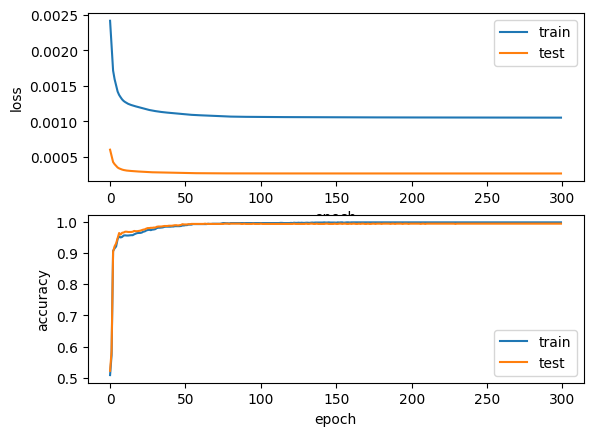

In [3]:
DIRECTORY = "../formatted"
LABELS = ["8-302", "8-303"]
TIME_WINDOW = 60

DATA_SIZE = 1500
TRAIN_RATIO = 0.6
BATCH_SIZE = 300
EPOCHS = 300

# データの読み込み
df_8302 = pd.read_csv(f"{DIRECTORY}/formatted_8-302_t={TIME_WINDOW}.csv")
df_8303 = pd.read_csv(f"{DIRECTORY}/formatted_8-303_t={TIME_WINDOW}.csv")
df_8302 = df_8302.sample(n=DATA_SIZE)
df_8303 = df_8303.sample(n=DATA_SIZE)
df = pd.concat([df_8302, df_8303])

# トレインデータとテストデータに分割
df = df.sample(frac=1)
x = df.drop(columns=["label"])
t = df["label"]
t = pd.get_dummies(t)

x = torch.tensor(x.values, dtype=torch.float32)
t = torch.tensor(t.values, dtype=torch.float32)

dataset = torch.utils.data.TensorDataset(x, t)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [TRAIN_RATIO, 1-TRAIN_RATIO])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)


# モデルの定義
model = AquaBleClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# 学習
train_losses = []
test_losses = []
train_accs = []
test_accs = []
for epoch in range(EPOCHS):
    model.train()
    # ミニバッチ学習
    for x, t in train_loader:
        optimizer.zero_grad()
        y = model(x)
        loss = criterion(y, t)
        loss.backward()
        optimizer.step()

    # トレインデータでの評価
    model.eval()
    train_loss = 0
    train_acc = 0
    for x, t in train_loader:
        y = model(x)
        loss = criterion(y, t)
        train_loss += loss.item()
        argmax_y = torch.argmax(y, dim=1)
        argmax_t = torch.argmax(t, dim=1)
        train_acc += torch.sum(argmax_y == argmax_t).item()
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)

    # テストデータでの評価
    test_loss = 0
    test_acc = 0
    for x, t in test_loader:
        y = model(x)
        loss = criterion(y, t)
        test_loss += loss.item()
        argmax_y = torch.argmax(y, dim=1)
        argmax_t = torch.argmax(t, dim=1)
        test_acc += torch.sum(argmax_y == argmax_t).item()
    test_loss /= len(test_loader.dataset)
    test_acc /= len(test_loader.dataset)
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accs.append(train_acc)
    test_accs.append(test_acc)

# 最終結果の表示
print(f"train_loss: {train_losses[-1]}, test_loss: {test_losses[-1]}")
print(f"train_acc: {train_accs[-1]}, test_acc: {test_accs[-1]}")

# プロット
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(train_losses, label="train")
ax1.plot(test_losses, label="test")
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss")
ax1.legend()

ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(train_accs, label="train")
ax2.plot(test_accs, label="test")
ax2.set_xlabel("epoch")
ax2.set_ylabel("accuracy")
ax2.legend()

plt.show()


In [4]:
# モデルの保存
OUTPUT_FILE = f"../model/model_t={TIME_WINDOW}.pth"
torch.save(model.state_dict(), OUTPUT_FILE)